## FirstCal Metrics Demo

Here we use the `FirstCal_Metrics` class within `firstcal_metrics.py` to assess the quality of firstcal solutions. Firstcal solutions are stored in `*first.calfits` files that are read on a file-by-file basis. This is only because the `pyuvadata.UVCal` class currently only supports file-by-file reading. 

**At the bottom** is a quick tutorial on how to use the command line tool `firstcal_metrics_run.py`.

In [1]:
%matplotlib inline
import numpy as np
import glob
import hera_qm
from hera_qm.data import DATA_PATH
import os
import fnmatch

In [2]:
# get files
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.first.calfits")))

### Example of Good FirstCal Delay Solutions

This is an example where FirstCal solutions are good, which in this case means excluding antenna 81 from the firstcal solutions (b/c its a dead antenna). This is something we exepct the AntMetrics to be able to pick up on, and is therefore a reasonable assumption.

In [3]:
f = fnmatch.filter(files, '*/zen.2457555.50099.yy.HH.uvcA.first.calfits')[0]
print f

/Users/nkern/Software/anaconda2/lib/python2.7/site-packages/hera_qm-0.0.0-py2.7.egg/hera_qm/data/zen.2457555.50099.yy.HH.uvcA.first.calfits


In [4]:
# initialize metrics class
FC = hera_qm.firstcal_metrics.FirstCal_Metrics(f)

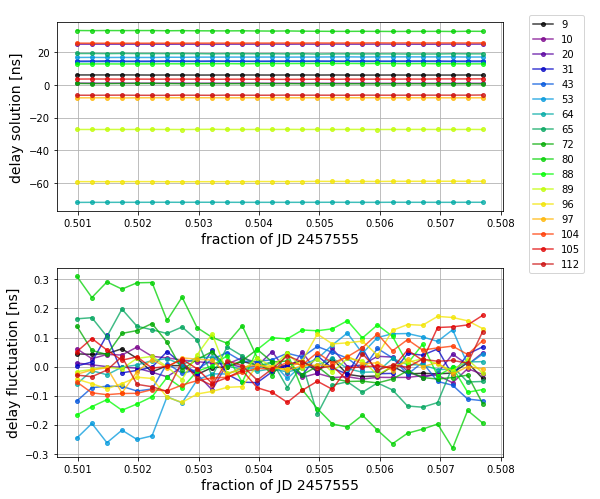

In [5]:
# inspect delays
FC.plot_delays()

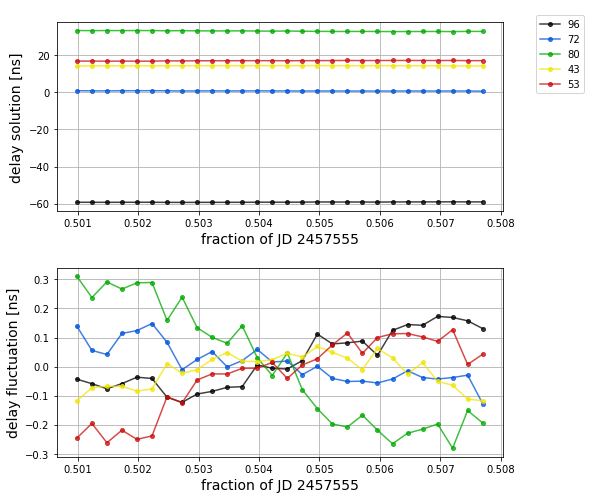

In [6]:
# inspect only a few antennas
FC.plot_delays(ants=[96, 72, 80, 43, 53])

Here we can see the delay solutions are for the most part stable over time, with the exception of a few antennas that show deviation on the ~0.5 ns scale. There are also particular times when solutions for all antennas are considerably worse than the average.

If we want to save this images to file, we can do so as well.

ls: ./*.png: No such file or directory


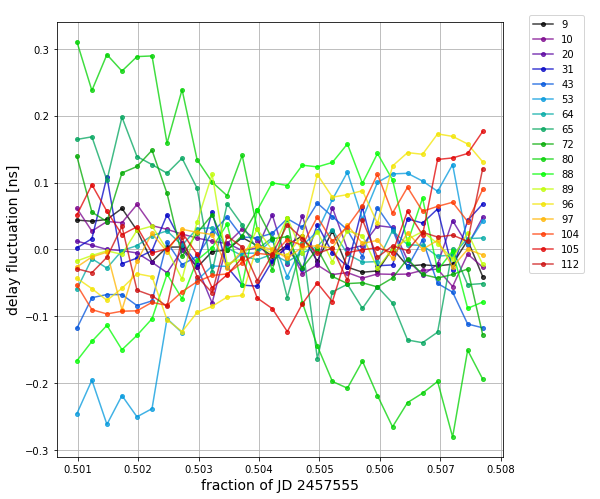

In [7]:
# inspect delay offsets and save to file
FC.plot_delays(plot_type='fluctuation', save=True)

# filename is by default calfits filestem + .png
!ls ./*.png

Now let's look at some quantitative metrics of the data. To do this, we need to run the FirstCal metrics, and we need to specify a hard cut on the delay solution standard deviation (in nanosec) as a criterion for "good" or "bad" solutions.

We can choose to feed a "rotated antenna" metrics json file, which will be appended to the firstcal_metrics dictionary.

In [8]:
FC.run_metrics(std_cut=0.5)

The resultant metrics are put into the `FC.metrics` dictionary.

In running the metrics, we get a determination of whether the whole solution across all antennas and time is good or bad if the aggregate standard deviation of the data is less than `std_cut`. This is the `good_sol` variable.

In [9]:
FC.metrics['good_sol']

True

We also get whether each antenna satisfies this condition, if it doesn't it is put into `bad_ants`.

In [10]:
FC.metrics['bad_ants']

[]

None of the individual antennas have stand. dev above `std_cut`, so `bad_ants` is empty.

We can also see if the antennas are deemed to be rotated by 180 degrees, and indeed one is.

In [11]:
FC.metrics['rot_ants']

[43]

Now let's plot those phase standard deviations!

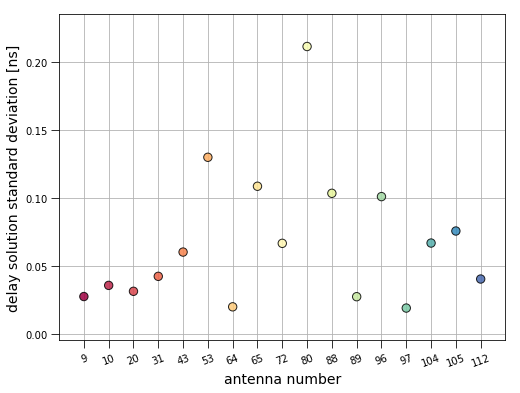

In [12]:
# plot standard deviation of delay solutions
FC.plot_stds()

We can see that all antennas have delay solution stand devs of less than 0.5 ns, which is not bad. It is apparent from this plot that, if we had to eliminate some antennas from the solution, antennas 80 and 96 would be good places to start.

We can also plot the antenna z-scores, which are defined to be the delay solution as a function of time and antenna number, having subtracted the delay median then divided by the aggregate stand. deviation.

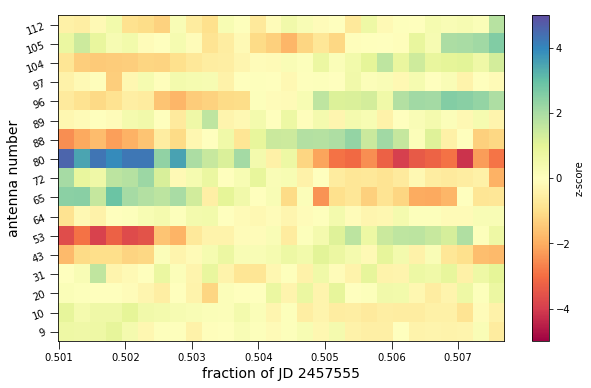

In [13]:
# plot z_scores of delay solutions
FC.plot_zscores()

We can also average the z-scores across time. To do so, we need to take the absolute value before averaging.

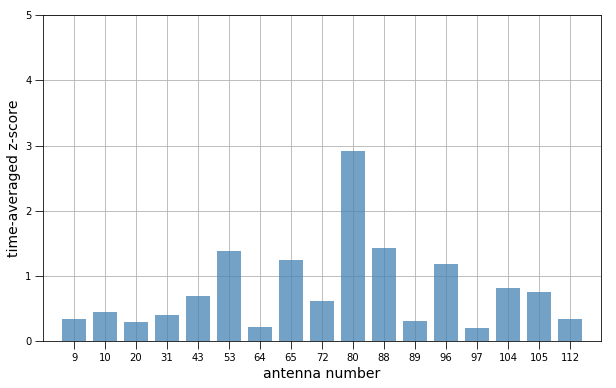

In [14]:
# plot z_scores of delay solutions averaged over time
FC.plot_zscores(plot_type='time_avg')

### command line tool `firstcal_metrics_run.py`

You can run firstcal metrics from the command line using the `firstcal_metrics_run.py` script, whose arguments are shown in the cell below.

To use it, you need to feed it a `*.first.calfits` file as a position argument. You can optionally feed it a `*.rotated_metric.json` file that contains a metric on possibly rotated antennas, which if fed will be propagated through to the output `*.firstcal_metrics.json` file via the `rot_ants` key. 

Given a directory structure as
```bash
./
zen.2457555.50099.yy.HH.uvcA.first.calfits
zen.2457555.50099.yy.HH.uvcA.first.calfits.rotated_metric.json
```
a standard usage would look like
```bash
firstcal_metrics_run.py --rotant_files=zen.2457555.50099.yy.HH.uvcA.first.calfits.rotated_metric.json zen.2457555.50099.yy.HH.uvcA.first.calfits
```


In [15]:
%%bash
firstcal_metrics_run.py --help

usage: firstcal_metrics.py [-h]
                           [--rotant_files [ROTANT_FILES [ROTANT_FILES ...]]]
                           [--std_cut STD_CUT] [--extension EXTENSION]
                           [--metrics_path METRICS_PATH]
                           [files [files ...]]

positional arguments:
  files                 *.calfits files for which to calculate
                        firstcal_metrics.

optional arguments:
  -h, --help            show this help message and exit
  --rotant_files [ROTANT_FILES [ROTANT_FILES ...]]
                        comma-delimited *.rotated_ants.json files
                        corresponding to *.calfits files.
  --std_cut STD_CUT     Delay standard deviation cut for good / bad
                        determination. Default 0.5
  --extension EXTENSION
                        Extension to be appended to the file name. Default is
                        ".firstcal_metrics.json"
  --metrics_path METRICS_PATH
                        Path to sav